In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (accuracy_score, precision_score,
                             recall_score, f1_score)
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (StandardScaler,
                                   OneHotEncoder)
from sklearn.tree import DecisionTreeClassifier, plot_tree

from my_awesome_eda import run_eda

Будем учиться классифицировать жанры музыки, полузуюсь не аудио дорожками, а уже осмысленными признаками (правда, не все из них имеют понятные названия). Сами данные можно найти [здесь](https://www.kaggle.com/purumalgi/music-genre-classification). Будем использовать файл `train.csv`. Нашей задачей будет предсказание переменной `Class` (жанр песни) при помощи деревьев решений. Можно попробовать также другие методы классификации, которые мы прошли, и сравнить результаты. При обучении всех моделей не забывайте про разделение на тренировку и тест (или кросс валидацию [ссылка](https://www.youtube.com/watch?v=fSytzGwwBVw)).

### Задание 1. EDA (10 баллов)

Как обычно, начнем с того, что посмотрим на наши данные: типы переменных, пропущенные значения, баланс классов и все такое. Ваш ход:

In [2]:
data = pd.read_csv("../data/raw_data/train.csv")
data.head()

,Artist Name,Track Name,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Class
0,Bruno Mars,That's What I Like (feat. Gucci Mane),60.0,0.854,0.564,1.0,-4.964,1,0.0485,0.017100,NaN,0.0849,0.8990,134.071,234596.0,4,5
1,Boston,Hitch a Ride,54.0,0.382,0.814,3.0,-7.230,1,0.0406,0.001100,0.004010,0.1010,0.5690,116.454,251733.0,4,10
2,The Raincoats,No Side to Fall In,35.0,0.434,0.614,6.0,-8.334,1,0.0525,0.486000,0.000196,0.3940,0.7870,147.681,109667.0,4,6
3,Deno,Lingo (feat. J.I & Chunkz),66.0,0.853,0.597,10.0,-6.528,0,0.0555,0.021200,NaN,0.1220,0.5690,107.033,173968.0,4,5
4,Red Hot Chili Peppers,Nobody Weird Like Me - Remastered,53.0,0.167,0.975,2.0,-4.279,1,0.2160,0.000169,0.016100,0.1720,0.0918,199.060,229960.0,4,10


Here is EDA for your dataframe ;)

Observations (rows): 17996
Parameters (features, columns): 17

Data types:
+--------------------+---------+-------------+
|                    |  dtype  |    type     |
+--------------------+---------+-------------+
| Artist Name        | object  |   string    |
| Track Name         | object  |   string    |
| Popularity         | float64 |  numerical  |
| danceability       | float64 |  numerical  |
| energy             | float64 |  numerical  |
| key                | float64 | categorical |
| loudness           | float64 |  numerical  |
| mode               |  int64  | categorical |
| speechiness        | float64 |  numerical  |
| acousticness       | float64 |  numerical  |
| instrumentalness   | float64 |  numerical  |
| liveness           | float64 |  numerical  |
| valence            | float64 |  numerical  |
| tempo              | float64 |  numerical  |
| duration_in min/ms | float64 |  numerical  |
| time_signature     |  int64  | categorical

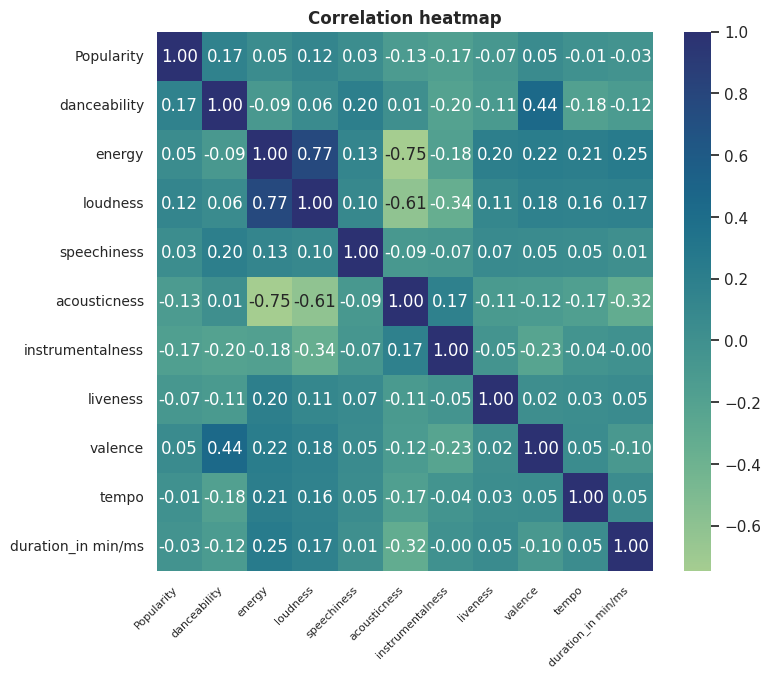


Outliers for numerical features:
------------------  ----
Popularity           469
danceability          31
energy                 0
loudness             818
speechiness         2034
acousticness           0
instrumentalness    6785
liveness             956
valence                0
tempo                 36
duration_in min/ms  3245
------------------  ----



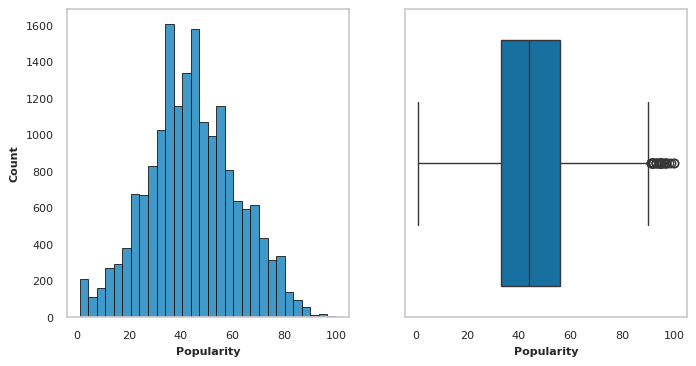

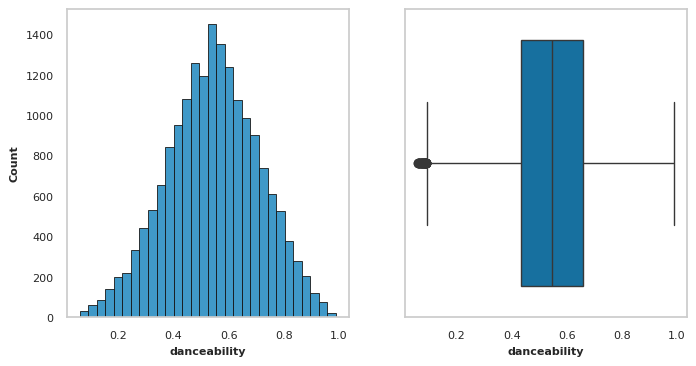

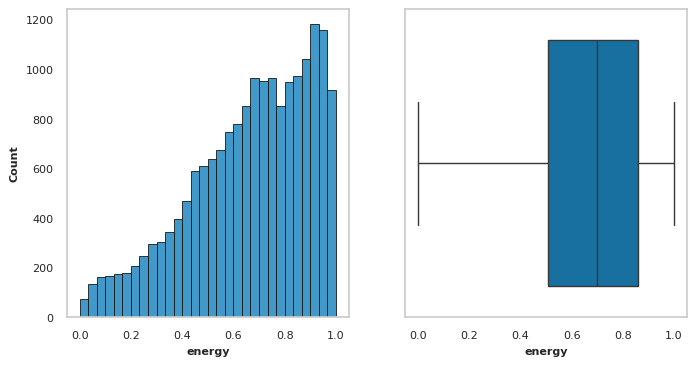

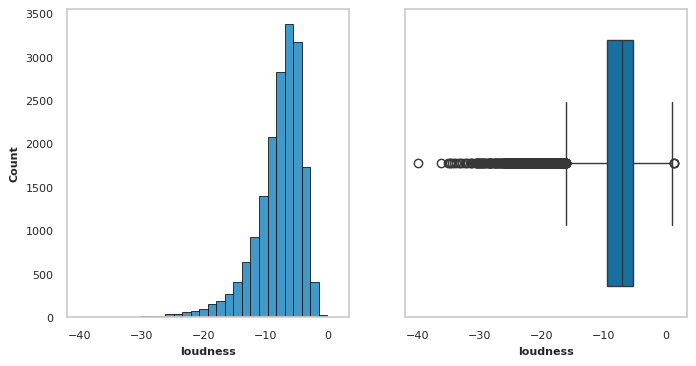

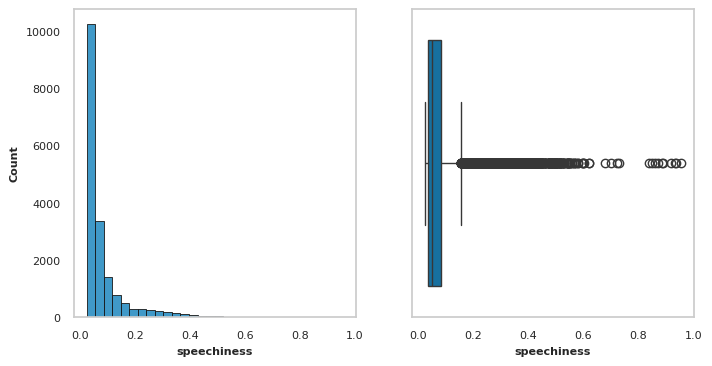

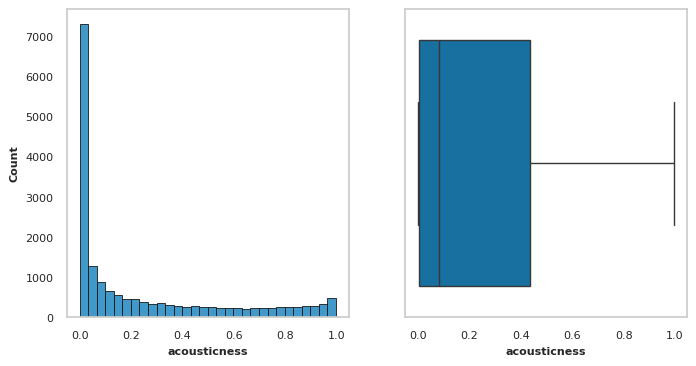

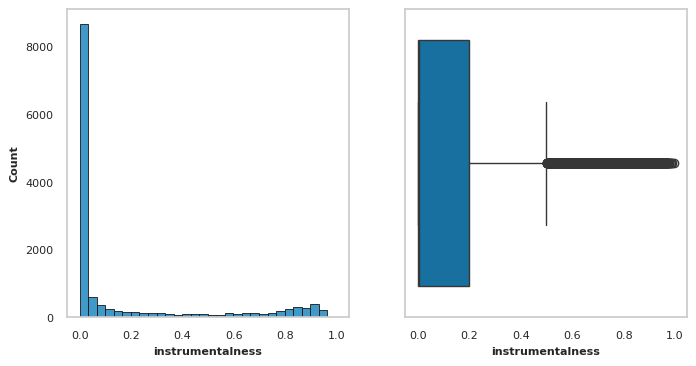

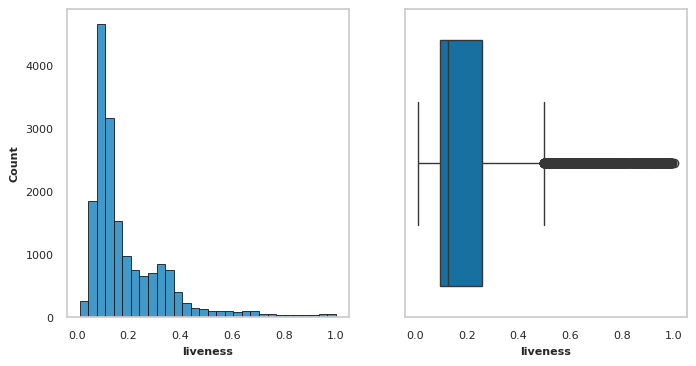

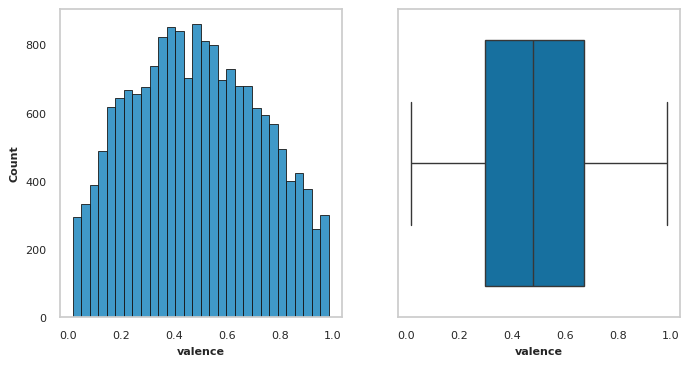

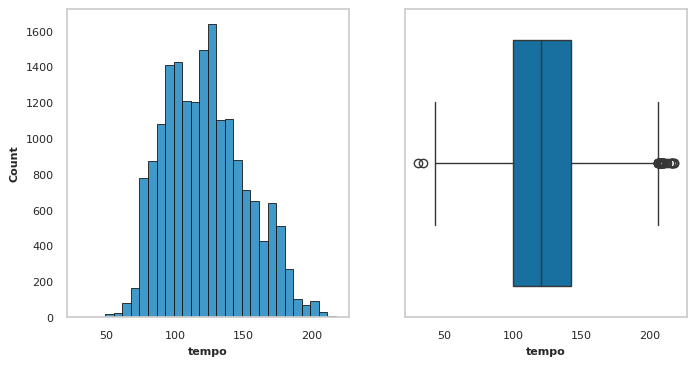

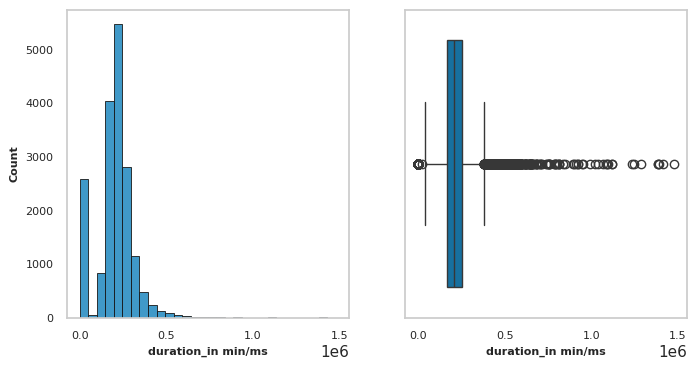


Missing values (NAs):
Total NA: 6819
Rows with NA: 6183
Columns with NA: ['Popularity' 'key' 'instrumentalness']



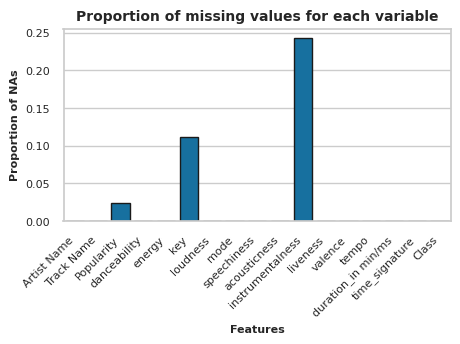


Number of duplicates (rows): 0


In [3]:
run_eda(data, category_threshold=12, correlation_figsize=(8, 7))

> Т.к. у нас всего **12 классов**, то я запустил EDA с таким же порогом для правильного определения категориальных колонок. По информации с kaggle, классы следующие: Rock, Indie, Alt, Pop, Metal, HipHop, Alt_Music, Blues, Acoustic/Folk, Instrumental, Country, Bollywood. Однако у нас их **<u>11</u>**, что немного странно

> 17996 наблюдений и 17 фич, большой датасет

> Получили такие строковые признаки:
- `Artist Name`: тут понятно, можем убирать
- `Track Name`: аналогично

> Получили следующие категориальные признаки:
- `key`: несмотря на то, что dtype float64, можно видеть, что всего 11 классов, и они даже более-менее сбалансированы, и при этом не совпадают с таргет-колонкой (upd. т.к. в итоге в таблице не 12, а 11 классов, то все совпадает), а значит потенциально может быть хорошей фичей для предсказания, довольно много пропущенных значений
- `mode`: бинарный признак
- `time_signature`: не очень понятно, что это, странная нумерация (1,3,4,5) и к тому же ужасный дисбаланс. Тем не менее, эти самые малочисленные категории могут быть хорошим предиктором для некоторых классов
- `Class`: наш target, и снова явный дисбаланс классов, что очень плохо

> Рассмотрим численные признаки и их описательные статистики:
- `Popularity`: значения в процентах от 0 до 100, есть пропущенные значения, распределение нормальное
- `danceability`: значения в процентах от 0 до 1, распределение нормальное
- `energy`: значения в процентах от 0 до 1, распределение ненормальное
- `loudness`: уже другой показатель, распределение смещено в сторону отрицательных значений
- `speechiness`: значения в процентах от 0 до 1, распределение ненормальное, больше всего значений ближе к 0
- `acousticness`: значения в процентах от 0 до 1, больше всего значений ближе к 0, в остальном более-менее равномерное
- `instrumentalness`: значения в процентах от 0 до 1, очень много пропущенных значений, больше всего значений ближе к 0, в остальном более-менее равномерное
- `liveness`: значения в процентах от 0 до 1, слабенькое бимодальное распределение, большинство значений в первой половине оси
- `valence`: значения в процентах от 0 до 1, распределение нормальное
- `tempo`: а этот признак явно не в процентах, распределение похоже на нормальное
- `duration_in min/ms`: минуты или миллисекунды, судя по распределению, большинство песен в миллисекундах, несмотря на это, для нас удобнее будет смотреть на минуты, поэтому конвертируем в минуты

> Корреляции:
- прямая (0.77) energy-loudness
- несильная прямая (0.44) valence-danceability
- обратная (-0.75) energy-acousticness
- обратная (-0.61) loudness-acousticness
> учитывая сильную корреляцию `energy` с `loudness` и `acousticness`, ее можно дропнуть

> Выбросы: как будто бы их много, но я попробую не удалять, потому что они собираются в отдельные распределения; однако некоторые прям явные, их удалим

### Задание 2. Обучение дерева решений (10 баллов)

Предобработайте признаки так, чтобы их можно было подать в модель дерева решений и обучите ее, постарайтесь подобрать оптимальные гиперпараметры, которые вам известны. Постарайтесь также обосновать выбор метрики в данном случае. При подборе гиперпараметров может помочь `GridSearchCV` [ссылка](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

In [4]:
# удалим первые 2 колонки
clean_data = data.drop(["Artist Name", "Track Name", "energy"], axis=1)
clean_data.head()

# удалим явные выбросы
clean_data = clean_data.drop(index=[
    np.argmin(clean_data["loudness"]),
    np.argmin(clean_data["tempo"]),
])

# если прогнать run_eda, то можно увидеть, что не совсем все удалилось, так что отфильтруем еще разок
clean_data = clean_data.drop(index=[
    np.argmin(clean_data["tempo"]),
])

In [5]:
# переведем миллисекунды в минуты в колонке с продолжительностью песни
clean_data["duration_in min/ms"] = clean_data["duration_in min/ms"].apply(lambda x: x / 60000 if x > 1000 else x)

In [6]:
cat_cols = ["key", "mode", "time_signature"]
num_cols = ["Popularity", "danceability", "loudness", "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "tempo", "duration_in min/ms"]

all_features = cat_cols + num_cols
target = clean_data["Class"].values

In [7]:
X = clean_data[all_features]
y = target

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=12345)

> Т.к. в целом данных много, то сделаем тест-выборку побольше, т.к. у нас есть дисбаланс классов и хотелось бы взять побольше значений для малочисленных классов

In [9]:
preprocessor = ColumnTransformer([
    ("scaler", StandardScaler(), num_cols),
    ("ohe", OneHotEncoder(drop="first"), cat_cols)
])
preprocessor

ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                 ['Popularity', 'danceability', 'loudness',
                                  'speechiness', 'acousticness',
                                  'instrumentalness', 'liveness', 'valence',
                                  'tempo', 'duration_in min/ms']),
                                ('ohe', OneHotEncoder(drop='first'),
                                 ['key', 'mode', 'time_signature'])])

In [10]:
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", DecisionTreeClassifier())
])

search_space = {
    "classifier__criterion": ["gini", "entropy"],
    "classifier__splitter": ["best", "random"],
    "classifier__max_depth": list(range(1, 16)),
    "classifier__min_samples_leaf": list(range(1, 21)),
    "classifier__min_samples_split": list(range(2, 6)),
    "classifier__class_weight": ["balanced", None],
}

model = GridSearchCV(pipeline, search_space, cv=5, scoring="f1_macro", n_jobs=-1)

> В качестве метрики я использовал `f1_macro`, потому что вычитал, что он неплохо подходит для несбалансированных классов

In [11]:
%%time

model.fit(X_train, y_train)

/home/artemvaska/BI/BI-ML-2024/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
24000 fits failed out of a total of 48000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
24000 fits failed with the following error:
Traceback (most recent call last):
  File "/home/artemvaska/BI/BI-ML-2024/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/artemvaska/BI/BI-ML-2024/venv/lib/python3.12/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/artemvaska/BI/BI-ML-2024/venv/

CPU times: user 33 s, sys: 3.9 s, total: 36.9 s
Wall time: 3min 38s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('scaler',
                                                                         StandardScaler(),
                                                                         ['Popularity',
                                                                          'danceability',
                                                                          'loudness',
                                                                          'speechiness',
                                                                          'acousticness',
                                                                          'instrumentalness',
                                                                          'liveness',
                                                                          'valence',
                                                                          'tempo',
                                                                          'duration_in '
                                                                          'min/ms']),
                                                                        ('ohe',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['key',
                                                                          'mode',
                                                                          'time_signature'])])),
                                       ('classifier',
                                        Decis...
             n_jobs=-1,
             param_grid={'classifier__class_weight': ['balanced', None],
                         'classifier__criterion': ['gini', 'entropy'],
                         'classifier__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13, 14, 15],
                         'classifier__min_samples_leaf': [1, 2, 3, 4, 5, 6, 7,
                                                          8, 9, 10, 11, 12, 13,
                                                          14, 15, 16, 17, 18,
                                                          19, 20],
                         'classifier__min_samples_split': [2, 3, 4, 5],
                         'classifier__splitter': ['best', 'random']},
             scoring='f1_macro')

> Я потратил достаточно много времени, чтобы разобраться, почему DT не работают с NaN, хотя с версии 1.4.2 scikit-learn'а все должно быть ок, но у меня не получилось. Поэтому просто оставлю как есть, кое-что в итоге нашлось, хоть мы и потеряли половину моделей

In [12]:
# лучшие гиперпараметры для модели
model.best_params_

{'classifier__class_weight': None,
 'classifier__criterion': 'entropy',
 'classifier__max_depth': 15,
 'classifier__min_samples_leaf': 15,
 'classifier__min_samples_split': 3,
 'classifier__splitter': 'best'}

In [13]:
# лучший f1_score
model.best_score_

0.38135003474088097

In [14]:
# предскажем значения по лучшей получившейся модели
best_model = model.best_estimator_
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

In [15]:
# оценим качество предсказания
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred, average="macro")}")
print(f"Recall: {recall_score(y_test, y_pred, average="macro")}")
print(f"F1-score: {f1_score(y_test, y_pred, average="macro")}")

Accuracy: 0.3991743410606542
Precision: 0.3879539954748022
Recall: 0.3721447723706511
F1-score: 0.3762051822216833


> Что ж, как-то так себе. Ладно, давайте нарисуем итоговый результат

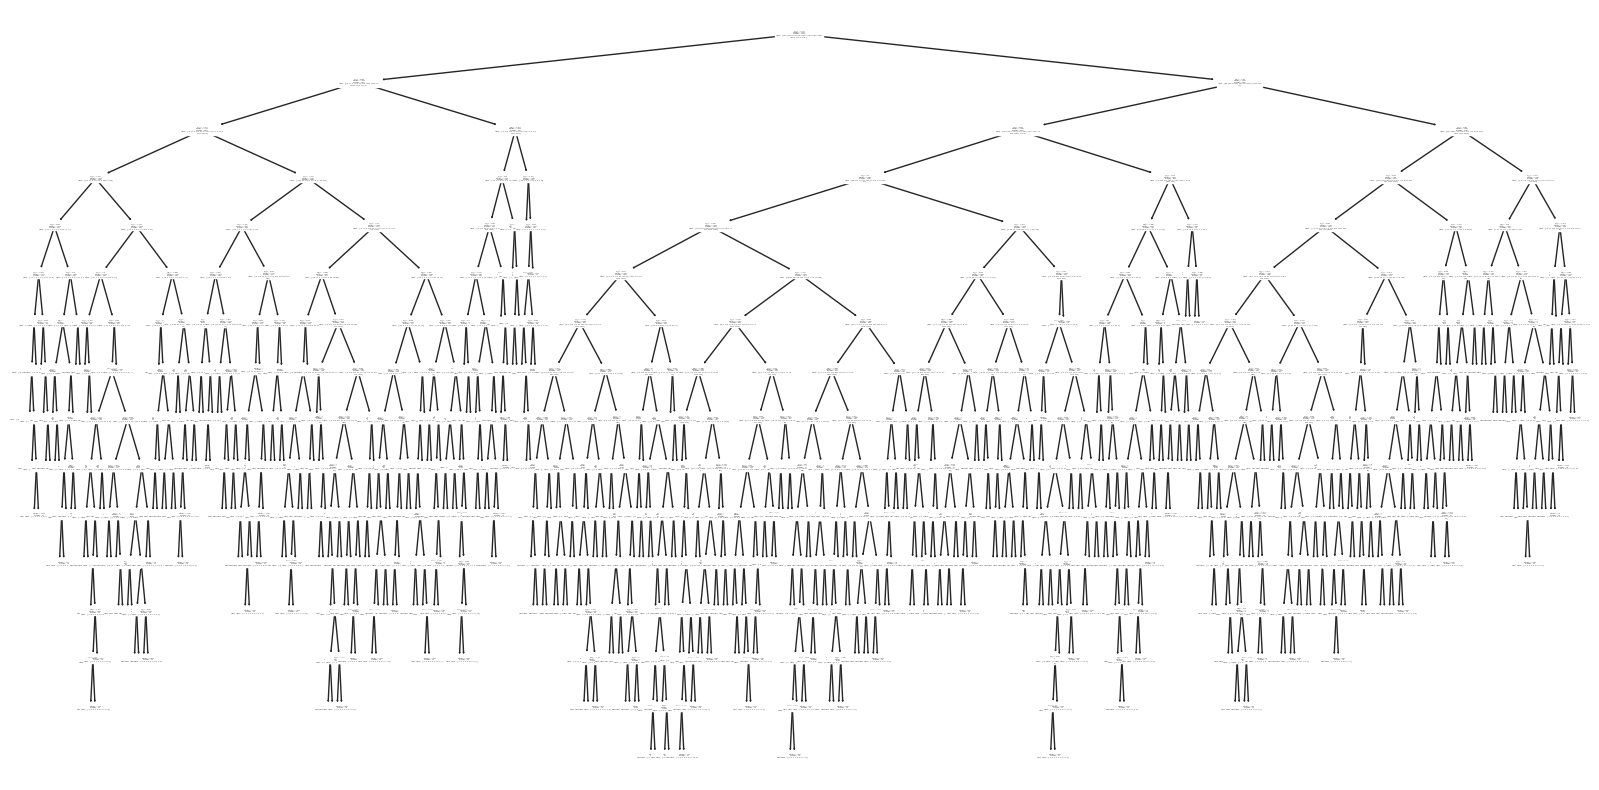

In [16]:
plt.figure(figsize=(20, 10))
plot_tree(best_model["classifier"])
plt.show();

> Ох ё, выглядит страшно

### Задание 3. Другие модели (без баллов, просто если есть желание)

Проделайте операции из **Задания 2** с другими известными вам классификаторами. Стало ли лучше?

### Задание 4. (0.5 доп. балла)

Расскажите про свои любимые фильмы, мультики и тд.

1. SAO (Sword Art Online): основоположник исэкаев, субъективно лучший в своем роде. История про парнишку, которого вместе с другими 20_000 игроками заперли в мире VR, где смерть в игре == смерть в реале, и чтобы выбраться отсюда, нужно пройти 100 уровней и победить главного босса

2. Naruto: ну это классика, сколько людей росли одновременно с гг и менялись тоже вместе с ним! Лично меня факт того, что 2 дня можно растянуть на 217 серий восхищает

3. Parasyte: немного биологии и экшона делает это аниме мега-интересным